# Sampling strategy 

## Preprocessing of the data

In [1]:
#load datasets
import geopandas as gpd
import pandas as pd
#ADD './join-datasets/' to the path
import sys
sys.path.append('../join-datasets/')
from constants import loading_dict, temporal_buffer, ddataset_profile, ddisturbance_profile, DCLASS_SCORE, dtypes, doa, dsbuffer

ddataset = {dataset_name : gpd.read_parquet(dataset_path) for dataset_name, dataset_path in loading_dict.items()}

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:

ddataset['firepolygons']['class'] = 'Fire'
#add end date with offset of 7 days 
ddataset['firepolygons']['end_date'] = pd.to_datetime(ddataset['firepolygons']['start_date']) + pd.to_timedelta(7, unit='d')

ddataset['bdiff']['class'] = 'Fire'
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
#filter bdiff geometry area < 100 1e6  m2
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].geometry.area <= 100e6 ]
#same for cdi 
ddataset['cdi'] = ddataset['cdi'][ ddataset['cdi'].geometry.area <= 100e6 ]
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


ddataset['bdiff'][['start_date', 'end_date']] = ddataset['bdiff'].apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

First, we load disturbances from all datasets. We have to rename 'cluster' to 'community'

In [2]:
#load communities 
mode = 'equal'
resolution = 100
dim = 2
temporal_threshold_ = 180 * 2
spatial_threshold_  = 600

all_disturbances = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

#filter disturbances by date 
#end_date should be greater than 2015 and and start_date should be less than 2020 
all_disturbances = all_disturbances[all_disturbances.end_date.dt.year >= 2017]
all_disturbances = all_disturbances[all_disturbances.start_date.dt.year <= 2020]

all_disturbances.rename(columns={'cluster':'community'}, inplace=True)

Then, we can perform a groupby (dissolve operation to take into account the geometry) on the 'community' column.

In [3]:
#dissolve by 'cluster'
communities = all_disturbances.dissolve(by='community', aggfunc='first')

#creating bounding boxes
# from shapely.geometry import box 
# #use itertuples to create a list of boxes from bounds of each geometry
# communities['bbox'] = [box(*row.geometry.bounds) for row in communities.itertuples()]


Now we can load the clusters (groups inside communities). We have to reindex and reasign the index to the cluster column to give a unique id for each cluster. 

In [4]:
method = 'HDBSCAN'
clusters = gpd.read_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")
#reindex and called previous index 'cluster'
clusters = clusters.reset_index().rename(columns={'index':'cluster'})

#filter clusters by date, End_date year should be greater than 2017 and Start_Date year should be less than 2020
clusters = clusters[clusters.End_Date.dt.year >= 2017]
clusters = clusters[clusters.Start_Date.dt.year <= 2020]

#get unique id for cluster +mcommunity 
clusters.drop(columns=['cluster'], inplace=True)
clusters = clusters.reset_index().rename(columns={'index':'cluster'})

Now we can build a GeoDataFrame that contains all disturbances and that has the columns 'cluster' and 'community'

In [5]:
# from tqdm import tqdm
# list_gdf = []
# all_disturbances.rename(columns={'cluster':'community'}, inplace=True)
# for i,row in tqdm(enumerate(clusters.itertuples())):
#     g = all_disturbances[all_disturbances.index.isin(row.Indexes)]
#     g['cluster'] = row.cluster
#     g['cluster_class'] = row.Class
#     g['start_date_cluster'] = row.Start_Date
#     g['end_date_cluster'] = row.End_Date
#     g['STR_cluster'] = row.Spatial_threshold 
#     g['TTR_cluster'] = row.Temporal_threshold
#     g['IS_cluster'] = row.IntraSimilarity
#     list_gdf.append(g)

# gdf_polygons = gpd.GeoDataFrame(pd.concat(list_gdf), geometry='geometry', crs=clusters.crs)
# gdf_polygons.to_parquet(f"../data/results/clusters/clusters_polygons_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

In [5]:
gdf_polygons = gpd.read_parquet(f"../data/results/clusters/clusters_polygons_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

Now we can regroup by clusters.

In [6]:
clusters_dissolved = gdf_polygons.dissolve(by='cluster', aggfunc='first')
#creating bounding boxes
# from shapely.geometry import box 
# #use itertuples to create a list of boxes from bounds of each geometry
# # clusters_dissolved['bbox'] = [box(*row.geometry.bounds) for row in clusters_dissolved.itertuples()]
# clusters_dissolved.reset_index(inplace=True)
# clusters_dissolved.geometry = clusters_dissolved.geometry.buffer(0).normalize()
# clusters_dissolved.to_parquet(f"../data/results/clusters/clusters_dissolved_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")
#filter by TTR and STR >= 0.5
clusters_dissolved_5 = clusters_dissolved[clusters_dissolved.TTR_cluster >= 0.5]
clusters_dissolved_5 = clusters_dissolved_5[clusters_dissolved_5.STR_cluster >= 0.5]


In [7]:
all_disturbances = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")


In [8]:
all_disturbances.dataset.value_counts()

dataset
senfseidl       692636
forms            41577
hm               19773
nfi               3493
bdiff             2928
cdi                834
firepolygons       147
Name: count, dtype: int64

all datasets of entit types are not present 

In [9]:
#read dbf with geopandas

greco = gpd.read_file('/Users/arthurcalvi/Data/eco-regions/France/ser_l93_new/ser_l93_new.dbf')
greco['greco'] = greco.codeser.apply(lambda x:x[0])
greco = greco.dissolve(by='greco', aggfunc='first')
greco = greco.reset_index().iloc[1:].to_crs('EPSG:2154')
greco.geometry = greco.geometry.simplify(1000).buffer(0)

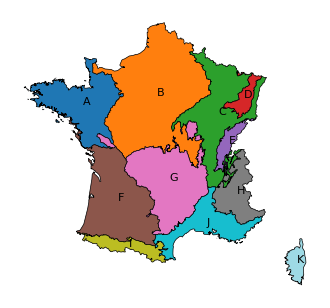

In [10]:
#plot greco with greco name on centroids
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
greco.plot(ax=ax, column='greco', edgecolor='black', linewidth=0.5, cmap='tab20')
for i, row in greco.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row.greco, fontsize=8)

ax.set_axis_off()
fig.savefig('../figures/greco.png', dpi=300, bbox_inches='tight')

## Actual Sampling

### First sampling round

Per region and per class

In [11]:
from tqdm import tqdm 
N = 10
samples = []
dict_remaining_samples = {}
dict_removed_communities = {}
for row in tqdm(greco.itertuples()):
    region = row.geometry
    clusters_region = clusters_dissolved_5.clip(region)
    #get clusters_region cluster_class name list by ascending order of count
    name_count = {n:c for n,c in clusters_region.cluster_class.value_counts().sort_values(ascending=False).items()}

    removed_communities = []
    dict_remaining_samples[row.greco] = {}
    for n,c in name_count.items():
        clusters_region_class = clusters_region[clusters_region.cluster_class == n].reset_index()
        community_count = clusters_region_class.community.nunique()
        #randomly sample N clusters from clusters_region_class
        
        nbr_samples = min([N,c, community_count])
        for i in range(nbr_samples):
            #drop removed community from clusters_region_class
            clusters_sampling = clusters_region_class[~clusters_region_class.community.isin(removed_communities)]

            if len(clusters_sampling) > 0:
                #sample 1 
                clusters_region_class_sample = clusters_sampling.sample(1)
                clusters_region_class_sample['greco'] = row.greco
                samples.append(clusters_region_class_sample)
                #add community to removed_communities
                removed_communities.append(clusters_region_class_sample.community.values[0])
            else : 
                print(f'no more samples in {n} for GRECO-{row.greco} - stopped at {i} samples')
        
        dict_remaining_samples[row.greco][n] = len(clusters_sampling) 
    dict_removed_communities[row.greco] = removed_communities
        
gdf_samples = gpd.GeoDataFrame(pd.concat(samples), crs=clusters_dissolved.crs, geometry='geometry')

1it [00:02,  2.13s/it]

no more samples in drought-dieback for GRECO-A - stopped at 7 samples
no more samples in drought-dieback for GRECO-A - stopped at 8 samples
no more samples in biotic-mortality for GRECO-A - stopped at 6 samples
no more samples in biotic-mortality for GRECO-A - stopped at 7 samples


4it [00:09,  2.30s/it]

no more samples in drought-dieback for GRECO-D - stopped at 6 samples


5it [00:10,  1.75s/it]

no more samples in drought-dieback for GRECO-E - stopped at 5 samples
no more samples in drought-dieback for GRECO-E - stopped at 6 samples


6it [00:14,  2.38s/it]

no more samples in drought-dieback for GRECO-F - stopped at 7 samples


8it [00:18,  2.18s/it]

no more samples in biotic-mortality for GRECO-H - stopped at 7 samples


9it [00:19,  1.65s/it]

no more samples in biotic-mortality for GRECO-I - stopped at 5 samples
no more samples in biotic-mortality for GRECO-I - stopped at 6 samples
no more samples in biotic-mortality for GRECO-I - stopped at 7 samples
no more samples in drought-dieback for GRECO-I - stopped at 1 samples
no more samples in drought-dieback for GRECO-I - stopped at 2 samples


10it [00:20,  1.44s/it]

no more samples in drought-dieback for GRECO-J - stopped at 5 samples
no more samples in biotic-mortality for GRECO-J - stopped at 3 samples
no more samples in biotic-mortality for GRECO-J - stopped at 4 samples
no more samples in biotic-mortality for GRECO-J - stopped at 5 samples


11it [00:20,  1.87s/it]

no more samples in storm for GRECO-K - stopped at 1 samples


<Axes: ylabel='cluster_class'>

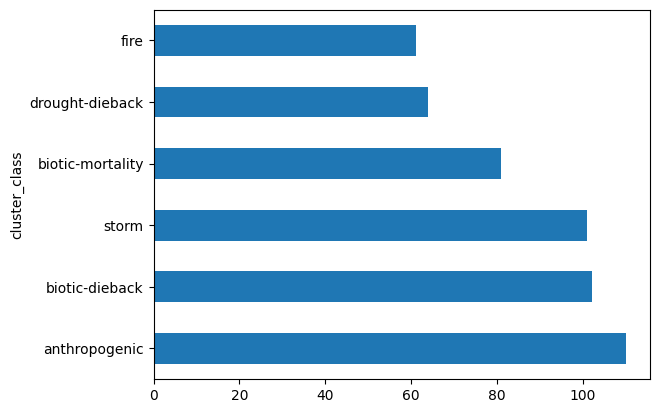

In [12]:
#hist of classes in gdf_samples
gdf_samples.cluster_class.value_counts().plot(kind='barh')

### Seond sampling round

We need to equalize the number of samples per disturbance class. So some regions will be oversampled for certain disturbance types. 

In [13]:
import random 
max_samples_per_class = N * 11 
#compute the number of samples per class in gdf_samples 
samples_per_class = gdf_samples.cluster_class.value_counts() 
#do the difference between max_samples_per_class and samples
diff = max_samples_per_class - samples_per_class
#select the classes with positive difference
positive_diff = diff[diff > 0]


# Step 3: Compute proportions and allocate additional samples
dict_new_samples = {}
for region in dict_remaining_samples:
    dict_new_samples[region] = {}
for class_needed, additional_samples_needed in positive_diff.items():
    # Compute total remaining samples for this class across all regions
    total_remaining_for_class = sum(dict_remaining_samples[region].get(class_needed, 0) for region in dict_remaining_samples)
    
    # If there are no remaining samples for this class, continue to next class
    if total_remaining_for_class == 0:
        continue
    
    # Compute and allocate additional samples for each region
    for region in dict_remaining_samples:
        remaining_in_region = dict_remaining_samples[region].get(class_needed, 0)
        
        # Skip if no remaining samples in this region for the class
        if remaining_in_region == 0:
            continue
        
        # Proportion of remaining samples in this region
        proportion = remaining_in_region / total_remaining_for_class
        
        # Additional samples to allocate to this region, rounded appropriately
        additional_for_region = round(proportion * additional_samples_needed)
        
        # Update or add the allocation for this class in this region
        if class_needed in dict_remaining_samples[region]:
            dict_new_samples[region][class_needed] = additional_for_region

In [14]:
dict_new_samples

{'A': {'biotic-dieback': 0, 'storm': 0},
 'B': {'biotic-dieback': 2,
  'storm': 2,
  'biotic-mortality': 4,
  'drought-dieback': 24,
  'fire': 0},
 'C': {'biotic-dieback': 3,
  'storm': 3,
  'biotic-mortality': 9,
  'drought-dieback': 15},
 'D': {'biotic-dieback': 1, 'storm': 1, 'biotic-mortality': 1},
 'E': {'biotic-dieback': 0, 'storm': 1, 'biotic-mortality': 1},
 'F': {'biotic-dieback': 1, 'storm': 1, 'biotic-mortality': 3, 'fire': 2},
 'G': {'biotic-dieback': 1,
  'storm': 1,
  'biotic-mortality': 12,
  'drought-dieback': 5,
  'fire': 1},
 'H': {'biotic-dieback': 0, 'storm': 0, 'drought-dieback': 1, 'fire': 1},
 'I': {'biotic-dieback': 0, 'storm': 0, 'fire': 3},
 'J': {'biotic-dieback': 0, 'storm': 0, 'fire': 24},
 'K': {'biotic-dieback': 0, 'fire': 17}}

In [15]:
from tqdm import tqdm 
N = 8
new_samples = []
for region, classes in tqdm(dict_new_samples.items()):

    state = False 
    for n, c in classes.items():
        if c > 0:
            state = True 

    if state:
        clusters_region = clusters_dissolved_5.clip(greco[greco.greco == region].geometry) #%TODO change to clusters_dissolved 
        removed_communities = dict_removed_communities[region]
        for n,c in classes.items():
            if c > 0:
                clusters_region_class = clusters_region[clusters_region.cluster_class == n].reset_index()

                community_count = clusters_region_class.community.nunique()
                nbr_samples = min([N,c, community_count])

                for i in range(nbr_samples):
                    #drop removed community from clusters_region_class
                    clusters_sampling = clusters_region_class[~clusters_region_class.community.isin(removed_communities)]

                    if len(clusters_sampling) > 0:
                        #sample 1 
                        clusters_region_class_sample = clusters_sampling.sample(1)
                        clusters_region_class_sample['greco'] = region 
                        new_samples.append(clusters_region_class_sample)
                        #add community to removed_communities
                        removed_communities.append(clusters_region_class_sample.community.values[0])
                    else : 
                        print(f'no more samples in {n} for GRECO-{region} - stopped at {i} samples')

gdf_new_samples = gpd.GeoDataFrame(pd.concat(new_samples), crs=clusters_dissolved.crs, geometry='geometry')

 64%|██████▎   | 7/11 [00:13<00:09,  2.40s/it]

no more samples in drought-dieback for GRECO-G - stopped at 3 samples
no more samples in drought-dieback for GRECO-G - stopped at 4 samples


 73%|███████▎  | 8/11 [00:14<00:05,  1.83s/it]

no more samples in drought-dieback for GRECO-H - stopped at 0 samples


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


<Axes: ylabel='cluster_class'>

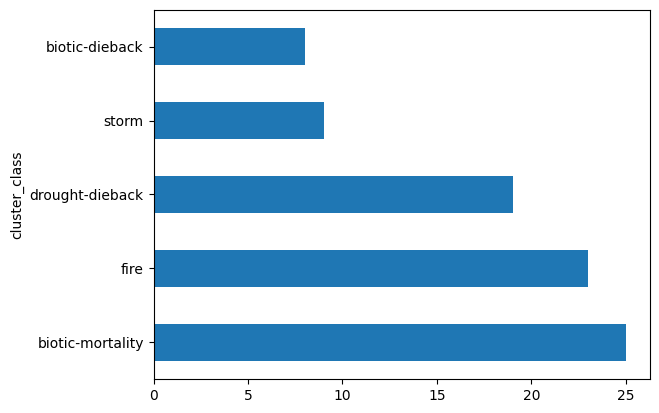

In [16]:
#hist of classes in gdf_samples
gdf_new_samples.cluster_class.value_counts().plot(kind='barh')

### Concatenation of first and second sampling rounds

In [17]:
#concat both samples
gdf_final_samples = pd.concat([gdf_samples, gdf_new_samples])
gdf_final_samples = gpd.GeoDataFrame(gdf_final_samples, crs=clusters_dissolved.crs, geometry='geometry')
gdf_final_samples.to_parquet(f'../data/results/clusters/samples_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet')

## Figures

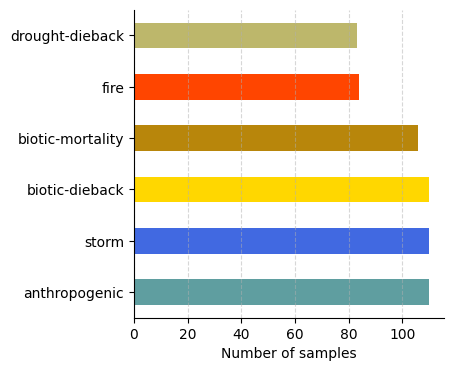

In [18]:
#hist of cluster_class in gdf_final_samples
import matplotlib.pyplot as plt
#use those colors : 
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}
fig, ax = plt.subplots(figsize=(4, 4))
gdf_final_samples.cluster_class.value_counts().plot(kind='barh', color=[custom_color_mapping.get(x, 'grey') for x in gdf_final_samples.cluster_class.value_counts().index])
#VERTICAL GRID
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of samples')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('../figures/samples_per_class.png', dpi=300, bbox_inches='tight')

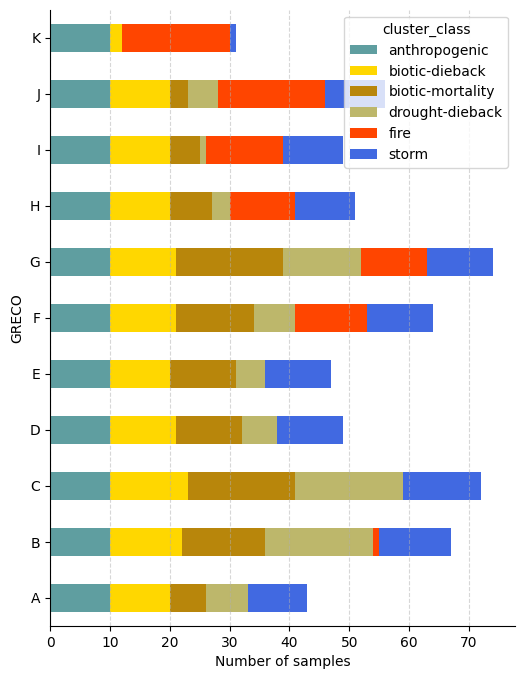

In [19]:
#figure histogram of class count per 'greco' column (region) on gdf sample
#use those colors : 
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 8))
gdf_final_samples.groupby('greco').cluster_class.value_counts().unstack().plot(kind='barh', stacked=True, ax=ax, color=custom_color_mapping)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#vertical grid
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of samples')
ax.set_ylabel('GRECO')
fig.savefig('../figures/samples_per_greco.png', dpi=300, bbox_inches='tight')

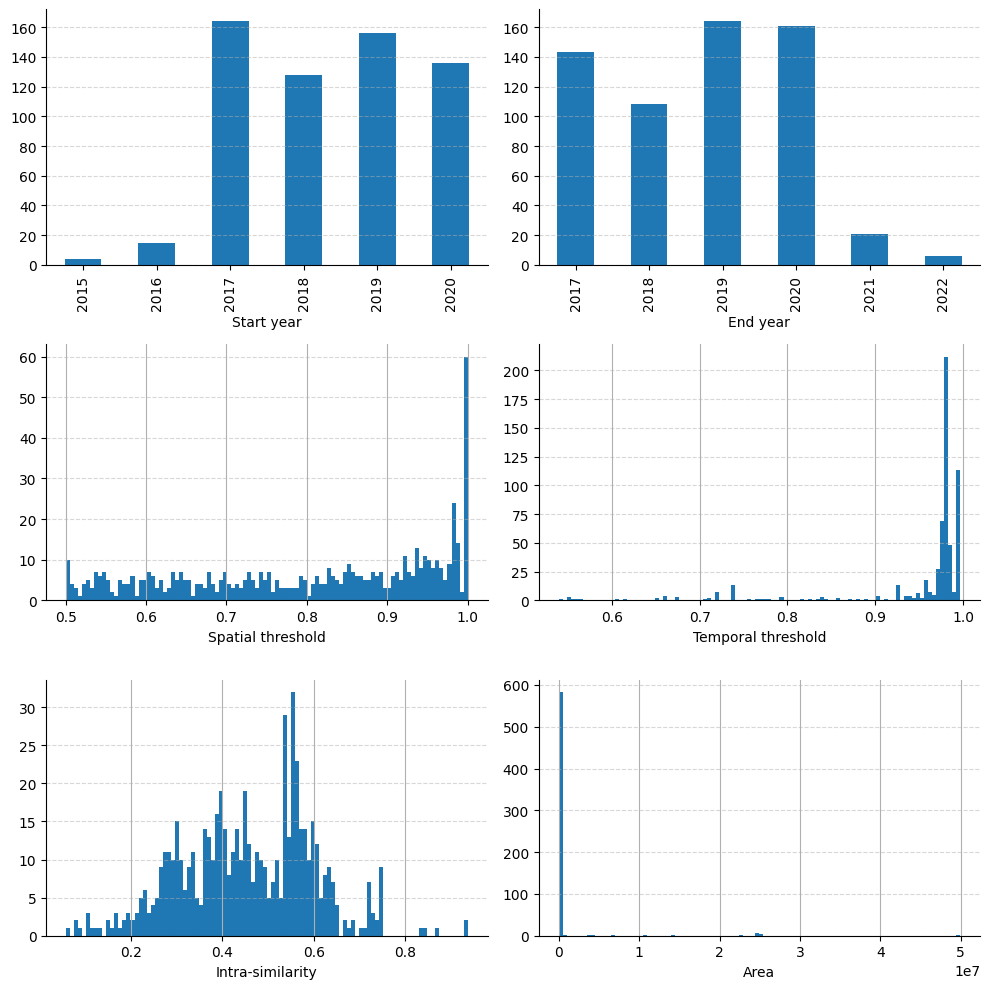

In [20]:
#histograms of start_date_cluster, end_date_cluster, STR_cluster, TTR_cluster, IS_cluster
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
gdf_final_samples.start_date_cluster.dt.year.value_counts().sort_index().plot(kind='bar', ax=axes[0,0])
gdf_final_samples.end_date_cluster.dt.year.value_counts().sort_index().plot(kind='bar', ax=axes[0,1])
gdf_final_samples.STR_cluster.hist(ax=axes[1,0], bins=100)
gdf_final_samples.TTR_cluster.hist(ax=axes[1,1], bins=100)
gdf_final_samples.IS_cluster.hist(ax=axes[2,0], bins=100)
gdf_final_samples.geometry.area.hist(ax=axes[2,1], bins=100)
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
axes[0,0].set_xlabel('Start year')
axes[0,1].set_xlabel('End year')
axes[1,0].set_xlabel('Spatial threshold')
axes[1,1].set_xlabel('Temporal threshold')
axes[2,0].set_xlabel('Intra-similarity')
axes[2,1].set_xlabel('Area')
plt.tight_layout()

Text(0.5, 0, 'Number of disturbances per cluster')

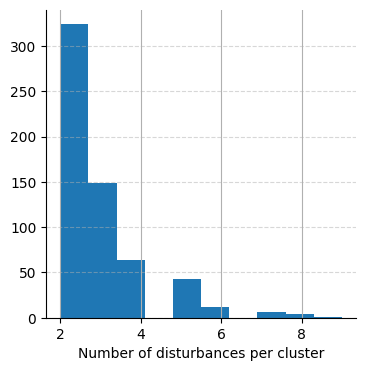

In [21]:
index_disturbances = gdf_final_samples.merge(clusters, on='cluster')[['Indexes', 'cluster_class']]
index_disturbances['count'] = index_disturbances.Indexes.apply(lambda x:len(x))

#histogram of count
fig, ax = plt.subplots(1,1, figsize=(4, 4))
index_disturbances['count'].hist(ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of disturbances per cluster')

In [22]:
list_gdf = []
for i,row in tqdm(enumerate(index_disturbances.itertuples())):
    g = all_disturbances[all_disturbances.index.isin(row.Indexes)]
    g['class'] = row.cluster_class
    list_gdf.append(g[['dataset', 'class']])

gdf_polygons_samples = pd.concat(list_gdf)

603it [00:09, 66.04it/s]


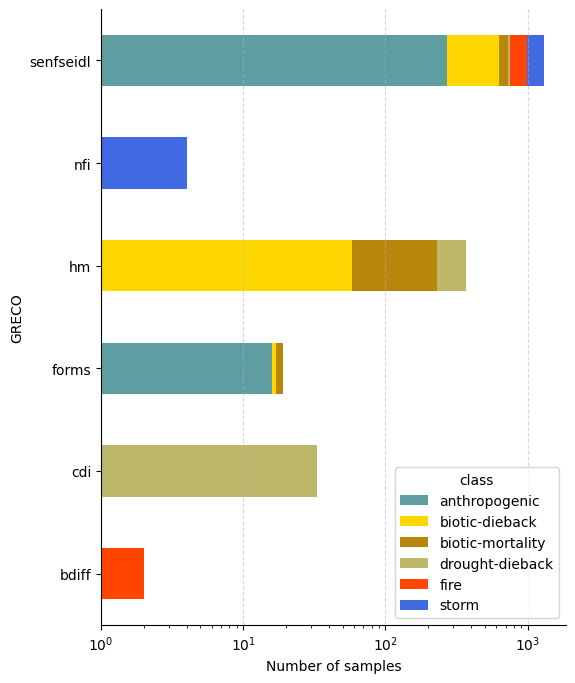

In [23]:
#use those colors : 
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 8))
gdf_polygons_samples.groupby('dataset')['class'].value_counts().unstack().plot(kind='barh', stacked=True, ax=ax, color=custom_color_mapping, log=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#vertical grid
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of samples')
ax.set_ylabel('GRECO')
fig.savefig('../figures/samples_per_dataset.png', dpi=300, bbox_inches='tight')

Seul 4 bases de données présentes sur les 8. Il faut regarder au niveau des communautés. Nous devons regarder la classe au niveau des clusters puis les datasets présents

In [24]:
comunities_final_samples = gdf_final_samples.community.unique()

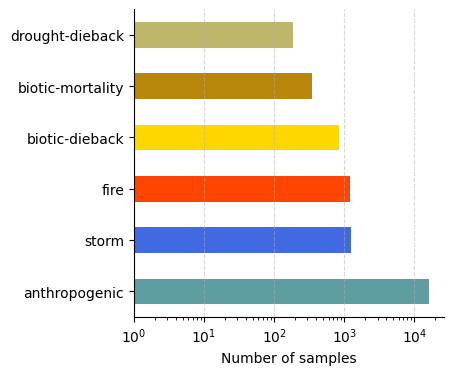

In [27]:
#sample per class

list_cluster_class = []
for c in comunities_final_samples:
    cluster_class = clusters_dissolved[clusters_dissolved.community == c].cluster_class.tolist()
    list_cluster_class.extend(cluster_class)

#nice histogram of cluster_class
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(4, 4))
pd.Series(list_cluster_class).value_counts().plot(ax=ax, kind='barh', color=[custom_color_mapping.get(x, 'grey') for x in pd.Series(list_cluster_class).value_counts().index], log=True)
#VERTICAL GRID
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of samples')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('../figures/samples_per_class.png', dpi=300, bbox_inches='tight')

In [28]:
pd.Series(list_cluster_class).value_counts()

anthropogenic       16312
storm                1234
fire                 1203
biotic-dieback        854
biotic-mortality      350
drought-dieback       186
Name: count, dtype: int64

In [29]:
gdf_polygons

,id,start_date,end_date,class,dataset,tree_type,essence,geometry,centroid_date,community,cluster,cluster_class,start_date_cluster,end_date_cluster,STR_cluster,TTR_cluster,IS_cluster
261894,1643655,2017-01-01,2017-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((766647.030 6654390.570, 766676.867 6...",2017-07-02 00:00:00,5,5,anthropogenic,2017-02-12 00:00:00,2017-11-19,0.856284,0.977973,0.750000
261896,1643657,2017-01-01,2017-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((766733.821 6654428.841, 766703.984 6...",2017-07-02 00:00:00,5,5,anthropogenic,2017-02-12 00:00:00,2017-11-19,0.856284,0.977973,0.750000
69153,56769,2018-01-01,2018-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((766617.193 6654387.763, 766647.030 6...",2018-07-02 00:00:00,5,6,anthropogenic,2018-02-11 00:00:00,2018-11-18,0.957978,0.977783,0.722597
69154,56770,2018-01-01,2018-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((766647.030 6654390.570, 766644.310 6...",2018-07-02 00:00:00,5,6,anthropogenic,2018-02-11 00:00:00,2018-11-18,0.957978,0.977783,0.722597
69155,56771,2018-01-01,2018-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((766611.754 6654447.469, 766641.590 6...",2018-07-02 00:00:00,5,6,anthropogenic,2018-02-11 00:00:00,2018-11-18,0.957978,0.977783,0.722597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740061,20397,2019-09-01,2020-05-01,clear-cut,forms,None,None,"POLYGON ((626520.159 6597688.901, 626530.159 6...",2019-12-31 12:00:00,30495,243826,anthropogenic,2010-12-27 18:00:00,2020-12-31,0.000000,0.000000,0.000000
467428,2122253,2020-01-01,2020-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((622924.552 6607622.683, 622954.396 6...",2020-07-01 12:00:00,30495,243826,anthropogenic,2010-12-27 18:00:00,2020-12-31,0.000000,0.000000,0.000000
241904,1619187,2017-01-01,2017-12-31,Other,senfseidl,Mixed,"broadleaf,nr","POLYGON ((631586.858 6592856.774, 631706.223 6...",2017-07-02 00:00:00,30495,243826,anthropogenic,2010-12-27 18:00:00,2020-12-31,0.000000,0.000000,0.000000
241906,1619190,2017-01-01,2017-12-31,Other,senfseidl,Broadleaf,broadleaf,"POLYGON ((628826.735 6596717.505, 628796.894 6...",2017-07-02 00:00:00,30495,243826,anthropogenic,2010-12-27 18:00:00,2020-12-31,0.000000,0.000000,0.000000


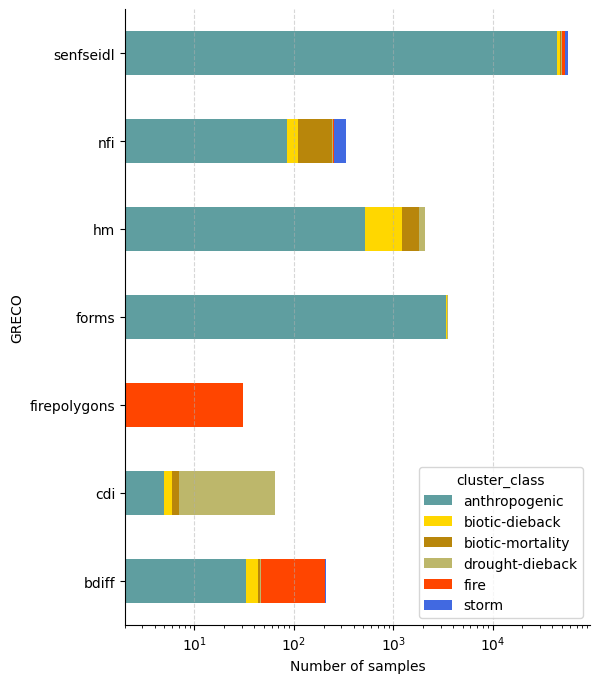

In [30]:
#dataset per class 
list_cluster_dataset = []
for c in comunities_final_samples:
    cluster_class = gdf_polygons[gdf_polygons.community == c][['cluster_class', 'dataset']]
    list_cluster_dataset.append(cluster_class)

df = pd.concat(list_cluster_dataset)
df = df.reset_index(drop=True)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 8))
df.groupby('dataset')['cluster_class'].value_counts().unstack().plot(kind='barh', stacked=True, ax=ax, color=custom_color_mapping, log=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#vertical grid
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of samples')
ax.set_ylabel('GRECO')
fig.savefig('../figures/samples_class_per_dataset_communitity_level.png', dpi=300, bbox_inches='tight')

In [31]:
df.groupby('dataset')['cluster_class'].value_counts()

dataset       cluster_class   
bdiff         fire                  161
              anthropogenic          33
              biotic-dieback         11
              biotic-mortality        2
              drought-dieback         1
              storm                   1
cdi           drought-dieback        57
              anthropogenic           5
              biotic-dieback          1
              biotic-mortality        1
firepolygons  fire                   29
              anthropogenic           2
forms         anthropogenic        3390
              biotic-mortality       64
              biotic-dieback         58
              drought-dieback        18
              fire                    7
              storm                   5
hm            biotic-dieback        701
              biotic-mortality      588
              anthropogenic         524
              drought-dieback       273
              fire                   17
              storm                   7
nfi      

nice, I have to check if the 0.5 threshold make sens, so I have to check dataset at this level. 
Also I have to change the probability per dataset : 1.0 for hm, nfi and fire polygons, much less for other. 